# SVM with linear kernel

The goal of this notebook is to find the best parameters for linear kernel. We also want to check if the parameters depend on stock.

Linear kernel is a function: $\langle x, x'\rangle$.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['3757', '4218', '4851', '3388', '3107']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 3757: 4380
Testing set length for 3757: 1459
Cross-validation set length for 3757: 1459
Training set length for 4218: 4362
Testing set length for 4218: 1453
Cross-validation set length for 4218: 1453
Training set length for 4851: 3317
Testing set length for 4851: 1105
Cross-validation set length for 4851: 1105
Training set length for 3388: 3983
Testing set length for 3388: 1327
Cross-validation set length for 3388: 1327
Training set length for 3107: 3481
Testing set length for 3107: 1159
Cross-validation set length for 3107: 1159


In [3]:
dfs[stocks[0]].head(5)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1459,2013-09-12 14:05:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 2809.0), (1620.0, 4290.0), (1621.0, ...",1616.0,1619.0,1617.5,2809.0,1101.0,0.0,-0.436829
1460,2013-09-12 14:15:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1618.0, 619.0), (1619.0, 2439.0), (1620.0, 3...",1616.0,1618.0,1617.0,619.0,698.0,1.0,0.059985
1461,2013-09-12 14:19:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1618.0, 334.0), (1619.0, 2629.0), (1620.0, 4...",1617.0,1618.0,1617.5,334.0,108.0,1.0,-0.511312
1462,2013-09-12 14:20:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 1794.0), (1620.0, 3025.0), (1621.0, ...",1617.0,1619.0,1618.0,1794.0,724.0,1.0,-0.424940
1463,2013-09-12 14:28:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 694.0), (1620.0, 1132.0), (1621.0, 2...",1618.0,1619.0,1618.5,694.0,246.0,1.0,-0.476596


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults. For the **linear** kernel according to documentation it's worth to check only the **C** parameter.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced.

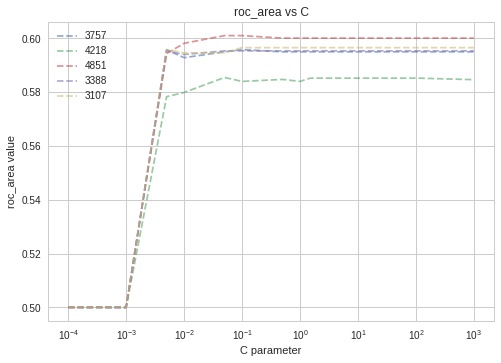

In [5]:
cs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 10, 100, 110, 1000]

df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'linear', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.6)
    df_css[s] = df_cs
plt.legend()
plt.xlabel('C parameter')
plt.ylabel('roc_area value')
plt.title('roc_area vs C')

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 3757 the best is 0.1
For 4218 the best is 0.05
For 4851 the best is 0.05
For 3388 the best is 0.005
For 3107 the best is 0.1


In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 3757 the diff between best and worst 0.09581994842095731
For 4218 the diff between best and worst 0.08548271743017355
For 4851 the diff between best and worst 0.10103644781365584
For 3388 the diff between best and worst 0.09536662423856712
For 3107 the diff between best and worst 0.09655527068924397


# Results

We compare results of SVMs with the best choice of **C** parameter against the logistic regression and SVM with defaults.

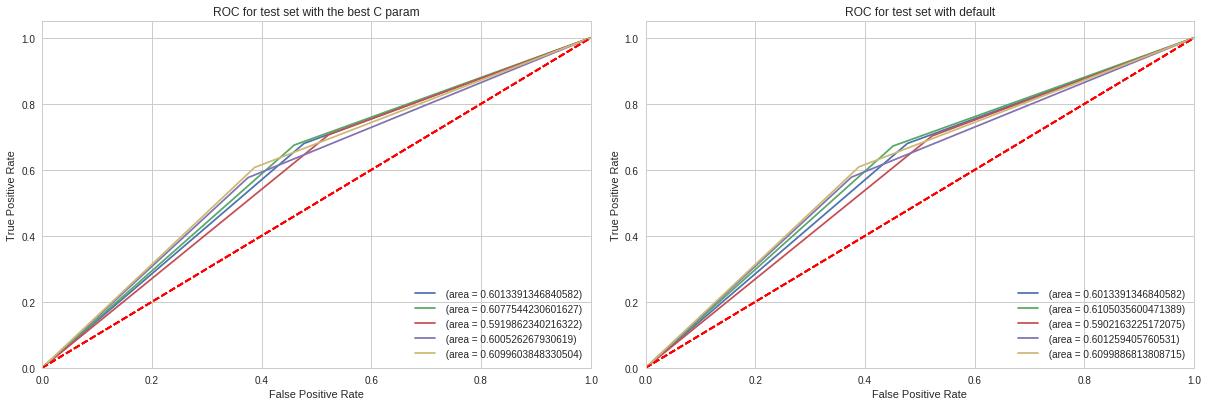

In [8]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['linear-default'] = np.zeros(len(stocks))
df_results['linear-tunned'] = np.zeros(len(stocks))

plt.subplot(121)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC for test set with the best C param')
    df_results['linear-tunned'][s] = score

plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC for test set with default')
    df_results['linear-default'][s] = score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

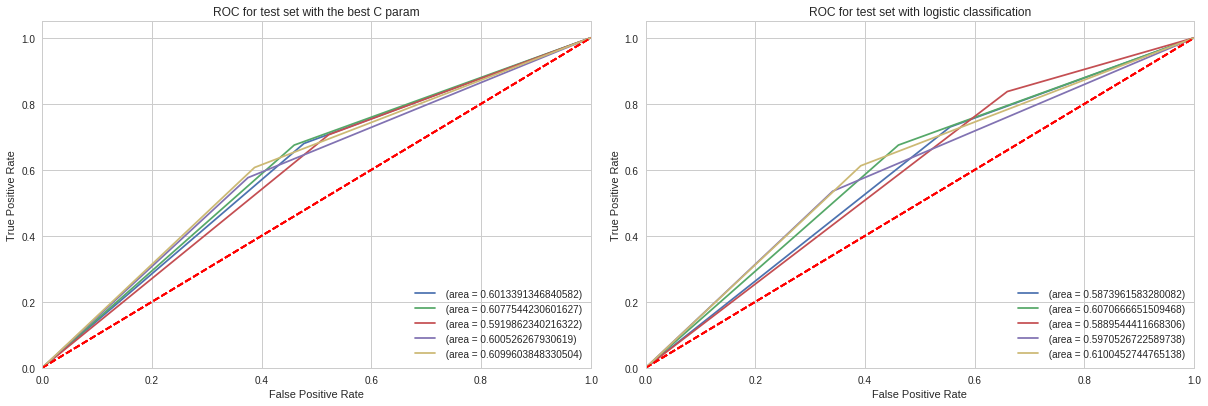

In [9]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    score = lob.plot_roc(dfs_test[s], reg_svm, title='ROC for test set with the best C param')
    df_results['linear-tunned'][s] = score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    
    score = lob.plot_roc(dfs_test[s], reg_log, title='ROC for test set with logistic classification')
    df_results['logistic'][s] = score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [10]:
df_results

,logistic,linear-default,linear-tunned
3757,0.587396,0.601339,0.601339
4218,0.607067,0.610504,0.607754
4851,0.588954,0.590216,0.591986
3388,0.597053,0.601259,0.600526
3107,0.610045,0.609989,0.609960


# Conclusions